# How to run
Run all cells using the combination CTRL + F9, images will be visualized using the best trained model "updatedmodel", the images will be outputed in the "Visualizing images" section. You can change the hyperparameters for the training in the hyperparameters section, just set the variable TRAIN to True, same for testing ( TEST variable ).

Note: train, test and visualization functions code is taken in part from https://colab.research.google.com/github/smartgeometry-ucl/dl4g/blob/master/colorization.ipynb#scrollTo=YDbY6pf2VU5T and adjusted to fit the use cases of this project.

### ENVIROMENT SETUP

In [1]:
# Clone repository
!git clone https://github.com/CristianTinaburri/ImageColorizationVisionAndPerception

# Copy contents
!cp -a /content/ImageColorizationVisionAndPerception/. /content/

# Clean Enviroment
!rm -rf /content/ImageColorizationVisionAndPerception
!rm -rf /content/sample_data

Cloning into 'ImageColorizationVisionAndPerception'...
remote: Enumerating objects: 60105, done.
remote: Counting objects: 100% (60105/60105), done.
remote: Compressing objects: 100% (86/86), done.
remote: Total 60105 (delta 60035), reused 60076 (delta 60016), pack-reused 0
Receiving objects: 100% (60105/60105), 20.54 MiB | 33.87 MiB/s, done.
Resolving deltas: 100% (60035/60035), done.
Checking out files: 100% (60014/60014), done.


In [2]:
# Clean folders
!rm -rf /content/training_images
!rm -rf /content/testing_images

!mkdir /content/training_images
!mkdir /content/testing_images

### LIBRARIES

In [1]:
# LIBRARIES
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision import datasets
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.transforms import ToTensor
from PIL import Image
import numpy as np

import os
import shutil
import pandas as pd
from torchvision.io import read_image
from skimage import color

from torch.utils.data import DataLoader

import cv2

import torchvision
from torchvision import models

import copy

### Hyperparameters

In [25]:
IMG_SIZE = 32       # image size
num_epochs = 250       # number of epochs to be performed during training
batch_size = 50        # batch size
learning_rate = 2e-4      # learning rate
betas = (0.9, 0.999)      # betas
eps = 1e-08       # eps
weight_decay = 2.5e-5     # weight_decay

use_gpu = True          # use_gpu
num_workers = 2          # num_workers
TRANSFORM_DATA = False      # apply transform to data
DATASET = "CIFAR"          # the dataset you want to use for training
MODEL_NAME = "updated_model" + ".pth"    # name of model to save
PATH_TO_SAVE_MODEL = "/content/gdrive/MyDrive/Computer Vision Project/Models/End Models/"   # where to save the model
MODEL_PATH_SAVE =  PATH_TO_SAVE_MODEL + MODEL_NAME + "/"    # complete variable to where to save the model
NUM_EPOCH_MODEL_SAVE = 5       # how many epoch to save model
TEST_EPOCHS = 10        # the number of epoch after it need to be tested
LOAD_MODEL = True   # if the model needs to be loaded
TRAIN = False   # if the model needs to be trained
TEST = False    # if the model needs to be tested

### Dataset Functions

In [26]:
%cd modules

import utils

%cd ..

utils.copy_dataset_for_training('datasets/' + DATASET)
number_files_training, number_files_testing = utils.get_number_of_images()

/content/modules
/content
5000
1000


In [27]:
if TRANSFORM_DATA == True:
  transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Resize((IMG_SIZE,IMG_SIZE)), transforms.ToPILImage()])
else:
  transform = None

In [28]:
%cd modules

import dataset

# Setup data
train_set = dataset.ImageDataset("/content/training_images", transform = transform)
test_set = dataset.ImageDataset("/content/testing_images", transform = transform)

# Setup dataloaders
train_dataloader = DataLoader(train_set, num_workers=num_workers, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_set, num_workers=num_workers, batch_size=batch_size, shuffle=False)

%cd ..

/content/modules
/content


### Models

In [29]:
# THIS CELL IMPORTS THE MODELS

%cd models

import colorfulcolorization
import basemodel
import updatedmodel
import colornetblock
import ResNetBackbone18

colorfulcolorization = colorfulcolorization.colorfulcolorization()
basemodel = basemodel.basemodel()
updatedmodel = updatedmodel.updatedmodel()
ResNetBackbone18 = ResNetBackbone18.ResNetBackbone18(p=0.8)
colornetblock = colornetblock.colornetblock(dim=128, percentage_dropout=0.5)

%cd ..

/content/models
/content


In [30]:
# THIS CELL INITIALIZE THE CHOOSEN MODEL

# Initialize model
# CHANGE THIS LINE TO THE MODEL ARCHITECTURE YOU WANT
model = updatedmodel

# Initialize device
device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")

# Port model to device
model = model.to(device)

# Print number of parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of parameters: %d' % (num_params))

# Import libraries to get summary of model architecture
from torchvision import models
from torchsummary import summary

# Get summary of model architecture
summary(model, (1,32,32))

Number of parameters: 128104
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]             640
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
   ConvTranspose2d-4           [-1, 64, 32, 32]           4,160
            Conv2d-5           [-1, 64, 32, 32]          36,928
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
           Dropout-8           [-1, 64, 32, 32]               0
            Conv2d-9           [-1, 64, 32, 32]          36,928
      BatchNorm2d-10           [-1, 64, 32, 32]             128
             ReLU-11           [-1, 64, 32, 32]               0
          Dropout-12           [-1, 64, 32, 32]               0
           Conv2d-13           [-1, 32, 32, 32]          18,464
      Batc

In [31]:
if LOAD_MODEL == True:
  MODEL_PATH_TO_LOAD = "/content/models/pretrained/" + MODEL_NAME
  model.load_state_dict(copy.deepcopy(torch.load(MODEL_PATH_TO_LOAD, device)))
  model.eval()

### Training

In [32]:
# Loss function
loss_function = nn.MSELoss()

# Optimizer
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate, betas=betas, eps=eps, weight_decay=weight_decay)

In [33]:
if TRAIN == True:
  # set to training mode
  model.train()

  train_loss_avg = []

  print('Training Started')
  for epoch in range(num_epochs):
      train_loss_avg.append(0)
      num_batches = 0

      if epoch % NUM_EPOCH_MODEL_SAVE == 0 and epoch != 0:
        torch.save(model.state_dict(), MODEL_PATH_SAVE + MODEL_NAME + "_" + str(int(epoch)) + ".pth")
        pass

      if epoch % 10 == 0 and epoch != 0:
        utils.save_predictions()
        pass
      
      for l, ab in train_dataloader:
          
          l, ab = l.to(device), ab.to(device)

          predicted_ab_batch = model(l)
          
          loss = loss_function(predicted_ab_batch, ab)
          
          optimizer.zero_grad()
          loss.backward()
          
          optimizer.step()

          train_loss_avg[-1] += loss.item()
          num_batches += 1

          if num_batches*batch_size % int(number_files_training/10) == 0 and num_batches > 0:
            print(num_batches*batch_size, " / ", number_files_training)
          
      train_loss_avg[-1] /= num_batches
      print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

  torch.save(model.state_dict(), MODEL_PATH_SAVE + MODEL_NAME + "_" + str(int(epoch)) + ".pth")

### Testing

In [34]:
if TEST == True:
  model.eval()

  test_loss_avg, num_batches = 0, 0

  for l, ab in test_dataloader:

      with torch.no_grad():

          l, ab = l.to(device), ab.to(device)

          predicted_ab_batch = model(l)
          
          loss = loss_function(predicted_ab_batch, ab)

          test_loss_avg += loss.item()
          num_batches += 1
      
  test_loss_avg /= num_batches
  print('average loss: %f' % (test_loss_avg))

### Visualizing images

torch.Size([5, 1, 32, 32])
torch.Size([5, 2, 32, 32])


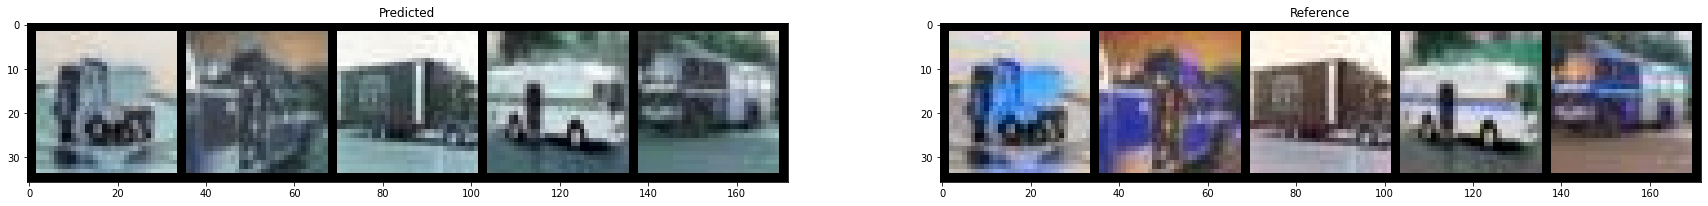

In [35]:
import numpy as np
from skimage import color, io

import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

number_of_images_grid = 5

with torch.no_grad():

    # BATCH DI TEST DI 10 IMMAGINI
    # ritorna un array con 10 numeri casuali 
    image_inds = np.random.choice(len(test_set), number_of_images_grid, replace=False)

    # ritorna un tensore cone i 10 elementi casuali
    lab_batch = torch.stack([torch.cat([test_set[i][0], test_set[i][1]], dim=0) for i in image_inds])

    # porta il lab_batch su gpu
    lab_batch = lab_batch.to(device)

    # dichiaro lista per le immagini da predirre
    predicted_lab_batch = []

    # predice il canale l dell'immagine
    print(lab_batch[:, 0:1, :, :].shape)
    print(model(lab_batch[:, 0:1, :, :]).shape)
    predicted_lab_batch = torch.cat([lab_batch[:, 0:1, :, :], model(lab_batch[:, 0:1, :, :])], dim=1)

    # porta il batch sulla cpu
    lab_batch = lab_batch.cpu()

    # porta la batch predetta sulla cpu
    predicted_lab_batch = predicted_lab_batch.cpu()

    rgb_batch = []
    predicted_rgb_batch = []
    for i in range(lab_batch.size(0)):
        predicted_rgb_img = color.lab2rgb(np.transpose(predicted_lab_batch[i, :, :, :].numpy().astype('float64'), (1, 2, 0)))
        predicted_rgb_batch.append(torch.FloatTensor(np.transpose(predicted_rgb_img, (2, 0, 1))))

        rgb_img = color.lab2rgb(np.transpose(lab_batch[i, :, :, :].numpy().astype('float64'), (1, 2, 0)))
        rgb_batch.append(torch.FloatTensor(np.transpose(rgb_img, (2, 0, 1))))

    fig, ax = plt.subplots(figsize=(30, 30), nrows=1, ncols=2)
    ax[0].imshow(np.transpose(torchvision.utils.make_grid(torch.stack(predicted_rgb_batch), nrow=5).numpy(), (1, 2, 0)))
    ax[0].title.set_text('Predicted')
    ax[1].imshow(np.transpose(torchvision.utils.make_grid(torch.stack(rgb_batch), nrow=5).numpy(), (1, 2, 0)))
    ax[1].title.set_text('Reference')

    # plt.savefig(MODEL_PATH_SAVE + MODEL_NAME + '_' + str(250) + '.png', bbox_inches='tight')

    plt.show()
